
# **Introduction**
Proteins interact with a variety of molecules including substrates, drugs, and other molecules which are involved in their function or regulating their function. Before an experiment, sometimes it is helpful to know if and where a molecule might bind. This information can be obtained virtually through a process called **docking**. In a docking experiment, a receptor (typically a protein) and a ligand are virtually constructed and then the computer attempts to make good chemical interactions between the ligand and protein. One of the challenges is knowing where on the protein and to which amino acids the ligand might interact. There are algorithms that can *predict* binding sites or pockets which are based on known or experimentally supported information. Predictions from docking are good for making a hypothesis about whether a protein can be regulated by a molecule or drug which can then be verfied experimentally.

A video on [Virtual Docking](https://youtu.be/8Q0tk6HtRuc?si=OaTWQ4J_qLD4V-F2).

## What will I get from this Colab?
This colab identifies potential binding sites and how a ligand may fit into one of those sites. Comparison of the ligand binding values between sites can provide information on the liklihood a molecule interacts at that site, which can be verified experimentally.



---



####**Please make a copy of this colab for your personal use!!**

A few things to start:

1.   These lessons only work in Google Chrome
2.   If you want to save your progress, go to File> Save a Copy in Drive; then locate a spot in your Drive folder
3.   Clicking the "play" button to the top left of a code block runs the code. Sometimes you can see the code and interact with it. However, if the code is hidden  it is to run adminstrative tasks in the background and you do not need to worry unless you are interested.
4. Sometimes the code may be hidden from view. To view it, click the '>' on the left of the title, until it changes to 'v'. This will reveal the code in that line.

Here are the files you will need for this code to run:
*  A  file containing a set of atomic coordinates of your receptor (usually protein) molecule either in **.cif** or **.pdb** format. pdb stands for a Protein Data Bank file. .cif files can be produced by AlphaFold3 or Boltz or downloaded from the PDB. In all cases, the file contains the three-dimensional structural data of your protein. If you run into errors with your .cif of .pdb file, ask your instructor.
*  A **SMILES string** for a ligand that you believe binds to your protein. [PubChem](https://pubchem.ncbi.nlm.nih.gov/) is a good resource to find SMILES strings for various ligands. We recommend using the canonical SMILES string if possible.
NOTE: At this time Phosphorus containing compounds cannot be modeled. For phosphates may try substituting Sulfate instead, however this will not exactly model the phosphate structure.

If you would like a tutorial on Python basics, please reference [this colab](https://colab.research.google.com/drive/1UVupXh23ArJp2F9vqTmkVh0JnjEaemi1?usp=sharing ). It is not necessary to do this, however if you are interested in learning more about coding it is a great resource to use!

If anything goes wrong as you are running this code and you would like to restart, click "Runtime" at the top of the screen, then press "Restart session". This will competely restart your run, so make sure that is what you want!

This code should take less than 1 hour to run for a single site. Comparison of sites will increase the run time.

---

This document has a list of [Frequently Asked Questions](https://docs.google.com/document/d/1kzkOi1T6QYjcyIoMXpU114B15WE0VcGnof5xvG5zdvA/edit?usp=sharing), reach out to your instructor if you have additional questions.

---

**Acknowledgments**
- This Colab was adapted by Chris Berndsen from a notebook written by Pablo R. Arantes in 2024. Please see the original [Uni-dock notebook](https://colab.research.google.com/github/pablo-arantes/Cloud-Bind/blob/main/Uni_Dock.ipynb) for additional acknowledgements and information.
- For related notebooks see: [Cloud-Bind](https://github.com/pablo-arantes/Cloud-Bind)

---
---
# **Getting started**

The first thing we need to do is install all necessary libraries and packages for our simulation, which in simple terms is code that is needed to run other code. To install the packages you need, click the PLAY button on the left. These packages will load some settings that are needed to run the rest of the code.

It is also important to indicate what the code means. Any line that begins with a '#' contains a comment on the code. If the code is shown, it is important to read the '#' to know what the code is and potentially how to run it.


In [ ]:
#@title **1A: Install Conda Colab**
#@markdown Press PLAY. It will restart the session, don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
#@title **1B: Install dependencies**
#@markdown Only press PLAY **after** the Conda Colab has finished downloading and the crash warning appears. It will take several minutes, please wait :-)
# install dependencies
%%capture
import sys
import tarfile
import os

import subprocess
import sys

!rm -rf /usr/local/conda-meta/pinned
!pip -q install py3Dmol
!pip install git+https://github.com/pablo-arantes/biopandas
!pip install bio
!mamba install pytorch torchvision -c pytorch
!pip install torchani
!pip install ase
!mamba install -c conda-forge pdbfixer -y
!mamba install -c conda-forge parmed -y
!mamba install -c conda-forge openbabel -y
!mamba install -c conda-forge rdkit -y
!wget https://github.com/dptech-corp/Uni-Dock/releases/download/1.0.0/unidock
!chmod +x unidock
!wget https://github.com/rdk/p2rank/releases/download/2.4/p2rank_2.4.tar.gz

file = tarfile.open('p2rank_2.4.tar.gz')
file.extractall('/content/')
file.close()
os.remove('p2rank_2.4.tar.gz')

!pip install openmm
!pip install parmed

#load dependencies
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import parmed as pmd
#import pdbfixer
from biopandas.pdb import PandasPdb
import urllib.request
import numpy as np
import py3Dmol
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from matplotlib import colors

In [ ]:
#@title ### **1C: Import Google Drive**
#@markdown Click in the "Run" button to make your Google Drive accessible.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

---
---
# **2: Loading your .cif or .pdb file**

At this point, you should have all libraries and dependencies installed and all necessary input files already in your Google Drive folder. This is what you did in the last section! Now, you will upload the file that describes the structure of your protein. This file is called a .pdb file.

Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them.

*   **Query_PDB_ID** is where you will put the name of your .pdb of .cif file. Add the name where it says "xxx" and make sure that is matches exactly to what is in the folder. Make sure there are no spaces or capitalizations in the file name!
*  **Google_Drive_path** is where you will put the name of the google drive folder you want to store your data. After MyDrive/, paste the name of your folder where the "xxx" is. Do not remove the `/content/drive/myDrive` part of the filename. **Make sure there are no spaces in the folder name!**  


---
## **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed.

Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them.

**Please, don't use spaces in the files and folders names, i.e. MyDrive/protein_ligand and so on.**

In [ ]:
#@title **Please, provide the necessary input files below for receptor**:
#@markdown **Important:** Run the cell to prepare your receptor protein. The system needs to make sure that the .cif or .pdb file is a valid protein and get a list of the amino acids. If this step works, you will see files being created in the Google Drive folder.

#@markdown This step takes up to 3-5 minutes depending on the size and complexity of your protein. When the list of amino acids appears it should be done.

from openmm.app.pdbfile import PDBFile

import warnings
warnings.filterwarnings('ignore')
import os
from Bio.PDB import PDBParser, PDBIO, Select, MMCIFParser
from Bio.PDB import is_aa
import pandas as pd
from pdbfixer import PDBFixer
from openbabel import pybel

Google_Drive_Path = '/content/drive/MyDrive/xxxx' #@param {type:"string"}
workDir = Google_Drive_Path

workDir2 = os.path.join(workDir)
workDir_check = os.path.exists(workDir2)
if workDir_check == False:
  os.mkdir(workDir2)
else:
  pass

if os.path.exists(os.path.join(workDir, "name_residues.txt")):
  os.remove(os.path.join(workDir, "name_residues.txt"))
  os.remove(os.path.join(workDir,"name_residues_receptor.txt"))
else:
  pass

temp = os.path.join(workDir, "temp.pdb")
receptor = os.path.join(workDir, "receptor.pdb")
receptor_pdbqt = os.path.join(workDir, "receptor.pdbqt")
ligand = os.path.join(workDir, "ligand.pdbqt")



Query_PDB_ID = 'xxx.cif' #@param {type:"string"}

def cif_to_pdb(cif_file, pdb_file):

    parser = MMCIFParser()
    structure = parser.get_structure("structure", cif_file)

    io = PDBIO()
    io.set_structure(structure)
    io.save(pdb_file)


if Query_PDB_ID.endswith('.cif'):
    print("Converting cif to pdb")
    ciffile = os.path.join(workDir, str(Query_PDB_ID))
    pdbfile = os.path.join(workDir, str(Query_PDB_ID).replace('.cif', '.pdb'))
    cif_to_pdb(ciffile, pdbfile)

if Query_PDB_ID.endswith('.cif'):
    Query_PDB_ID = str(Query_PDB_ID).replace('.cif', '.pdb')
else:
    file_name = Query_PDB_ID

pdbfn = Query_PDB_ID
#url = 'https://files.rcsb.org/download/' + pdbfn
#outfnm = os.path.join(workDir, pdbfn)
#urllib.request.urlretrieve(url, outfnm)


outfnm = os.path.join(workDir, str(pdbfn))

ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']
ppdb.to_pdb(path=temp, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

#prepare receptor
ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=receptor, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

fixer = PDBFixer(filename=receptor)
fixer.removeHeterogens()
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(pH=7.4)
PDBFile.writeFile(fixer.topology, fixer.positions, open(receptor, 'w'))

path = '/content/'


def is_het(residue):
    res = residue.id[0]
    return res != " " and res != "W"

def aa(residue):
    res = residue.id[0]
    return res != "W"


class ResidueSelect(Select):
    def __init__(self, chain, residue):
        self.chain = chain
        self.residue = residue

    def accept_chain(self, chain):
        return chain.id == self.chain.id

    def accept_residue(self, residue):
        return residue == self.residue and aa(residue)

def extract_ligands(path):
    pdb = PDBParser().get_structure(temp, temp)
    io = PDBIO()
    io.set_structure(pdb)
    i = 1
    name_residues = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues.txt"), "a",))
          i += 1

extract_ligands(path)

def extract_ligands2(path):
    pdb = PDBParser().get_structure(receptor, receptor)
    io = PDBIO()
    io.set_structure(pdb)
    i2 = 1
    name_residues2 = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues2.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues_receptor.txt"), "a",))
          i2 += 1

extract_ligands2(path)

# mol= [m for m in pybel.readfile(filename=receptor, format='pdb')][0]
# out=pybel.Outputfile(filename=receptor_pdbqt,format='pdbqt',overwrite=True)
# pybel.Molecule()
# out.write(mol)
# out.close()

os.system("obabel -i pdb " + str(receptor) + " -o pdbqt -O " + str(receptor_pdbqt) + " -xr --partialcharge")

dataset = pd.read_csv(os.path.join(workDir, 'name_residues.txt'), delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df.iloc[:, [2]]
new = df.to_numpy()

dataset2 = pd.read_csv(os.path.join(workDir, 'name_residues_receptor.txt'), delimiter = " ", header=None)
df2 = pd.DataFrame(dataset2)
df2 = df2.iloc[:, [2]]
new2 = df2.to_numpy()

b = 1
res_number = []
for j in new2:
  res_number.append(b)
  b += 1

print("Residue" + " - "  + "Number" )
a = 1
for j in new:
  print(', '.join(j) + " - "  + str(a))
  a += 1

# Predict ligand-binding pockets from your protein structure using P2Rank
P2Rank is a stand-alone command line program that predicts ligand-binding pockets from a protein structure. It achieves high prediction success rates without relying on an external software for computation of complex features or on a database of known protein-ligand templates. You don't have to use these pockets but it can be helpful if you don't know where to start. Generally the pocket will contains the active site amino acids. If it is an allosteric site, it may be distant from the active site. So use these pockets to help identify regions and try a few!

P2Rank makes predictions by scoring and clustering points on the protein's solvent accessible surface. Ligandability score of individual points is determined by a machine learning based model trained on the dataset of known protein-ligand complexes. For more details see [here](https://github.com/rdk/p2rank).

The results will show a series of potential pockets. An example of the results is shown in the image below:

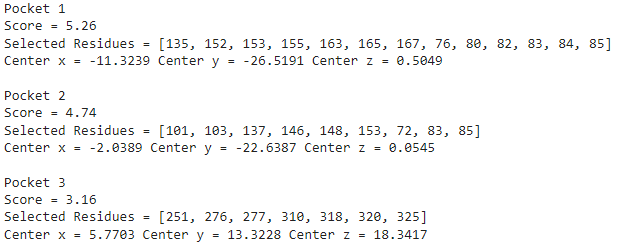

Each pocket described by the amino acids in the pocket, the relative center of the box, and the score, where higher is better.

In [ ]:
#@title **3: Predict ligand-binding pockets from your protein structure using P2Rank**:

#@markdown Press play to predict the pockets.

import subprocess
import csv

output_p2rank = os.path.join(workDir, "output_p2rank")
p2rank = "/content/p2rank_2.4/prank predict -f " + str(receptor) + " -o " + str(output_p2rank)
original_stdout = sys.stdout
with open('p2rank.sh', 'w') as f:
  sys.stdout = f
  print(p2rank)
  sys.stdout = original_stdout
subprocess.run(["chmod 700 p2rank.sh"], shell=True)
subprocess.run(["./p2rank.sh"], shell=True,)

with open(os.path.join(workDir, "output_p2rank/receptor.pdb_predictions.csv"), 'r') as file:
  csvreader = csv.reader(file)
  residue = []
  score = []
  center_x = []
  center_y = []
  center_z = []
  for row in csvreader:
    residue.append(row[9:10])
    score.append(row[2:3])
    center_x.append(row[6:7])
    center_y.append(row[7:8])
    center_z.append(row[8:9])

for i in range(1,len(residue)):
  file = str((residue[i])[0]).split()
  score_end = str((score[i])[0]).split()
  center_x_end = str((center_x[i])[0]).split()
  center_y_end = str((center_y[i])[0]).split()
  center_z_end = str((center_z[i])[0]).split()
  print("Pocket " + str(i))
  print("Score = " + score_end[0])
  final_residues = []
  for i in range(0,len(file)):
    test = file[i]
    final_residues.append(int(test[2:]))
  print("Selected Residues = " + str(final_residues))
  print("Center x = "+ str(center_x_end[0]), "Center y = "+ str(center_y_end[0]), "Center z = "+ str(center_z_end[0]) + "\n")

The results above should list one or more pockets with a score, amino acid numbers, and the "center" of the pocket. In the Google Drive folder, a new folder was created called **output_p2rank**, which contains two .csv files. The predictions file is the table above and a good summary of the results. The second file (generally called `receptor.pdb_residues.csv`) contains a list of the amino acids in the protein along with which pocket they may be a part of. A zero in pocket means it is not a part of the pocket. This file can be helpful for displaying the pockets in pyMol or Mol* or whatever visualization program that you use.

In [ ]:
#@title **4: Please, provide the pocket or residue number for the selection**:
#@markdown Select the pocket from above OR provide a list of residues. If you are unsure which to choose, select Pocket. The number is the pocket number listed above. Make sure that the resulting information below matches the list above and record this information for your report.

#@markdown **Important:** The selected pocket or residues will be used as a reference for the construction of an optimal box size for the ligand during the docking. If you want to select more than one residue, please, use comma to separate the numbers (i.e. 147,150,155,160). **Please, DO NOT USE SPACES BETWEEN THEM.**

import re
import csv

if os.path.exists(os.path.join(workDir, "name_residue.txt")):
  os.remove(os.path.join(workDir, "name_residue.txt"))
else:
  pass

# Python code to convert string to list
def Convert(string):
	li = list(string.split(","))
	return li

def extract_ligands(path,residues):
    pdb = PDBParser().get_structure(temp, temp)
    io = PDBIO()
    io.set_structure(pdb)
    i = 1
    name_residues = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          if i == int(residues):
            # print(residues)
            print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residue.txt"), "a",))
            io.save(f"res_{i}_certo.pdb", ResidueSelect(chain, residue))
          i += 1

Selection = "Pocket" #@param ["Pocket", "Residues"]

number = '1' #@param {type:"string"}

if Selection == "Pocket":
  file = str((residue[int(number)])[0]).split()
  score_end = str((score[int(number)])[0]).split()
  center_x_end = str((center_x[int(number)])[0]).split()
  center_y_end = str((center_y[int(number)])[0]).split()
  center_z_end = str((center_z[int(number)])[0]).split()
  center_x_gnina = float(center_x_end[0])
  center_y_gnina = float(center_y_end[0])
  center_z_gnina = float(center_z_end[0])
  print("Pocket " + str(number))
  print("Score = " + score_end[0])
  print("Center x = "+ str(center_x_end[0]), "Center y = "+ str(center_y_end[0]), "Center z = "+ str(center_z_end[0]) + "\n")
  final_residues = []
  for i in range(0,len(file)):
    test = file[i]
    final_residues.append(int(test[2:]))
  residues_num = final_residues
else:
  residues_num = Convert(number)

filenames=[]
for k in range(0, len(residues_num)):
  extract_ligands(path, residues_num[k])
  filenames.append(f"res_{residues_num[k]}_certo.pdb")


with open('selection_merge.pdb', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

# reading each line from original
# text file
file1 = open('/content/selection_merge.pdb', 'r')
file2 = open('/content/selection_merge_end.pdb','w')

for line in file1.readlines():

    # reading all lines that begin
    # with "TextGenerator"
    x = re.findall("^END", line)

    if not x:
        file2.write(line)

# close and save the files
file1.close()
file2.close()

dataset = pd.read_csv(os.path.join(workDir, "name_residue.txt"), delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df.iloc[:, [2]]
new = df.to_numpy()

print("Selected Residue" + " - "  + "Number" )
for j, i in zip(new, range(0, len(residues_num))):
# for j in new:
  print(', '.join(j) + " - "  + str(residues_num[i]))
res_box = '/content/selection_merge_end.pdb'

In [ ]:
#@title **5: Setting the grid box**:
#@markdown Now, we will use our ViewProtGrid to visualize the protein, binding site residues and a grid box of variable size and position that we can manipulate using a slider. If they are not already set to the X, Y, and Z values listed above, adjust the slides to the closest integer value. Then press play. The protein and box will be shown below. Ideally, the box encompasses the entire pocket.

#@markdown **NOTE:** It is highly likely that the Size of the box will be too small. Adjust it as needed. If you are unsure, leave the size along, complete the rest of the Colab, then come back and re-try the dock with a different size box. Ideally, the box size won't matter.

#These definitions will enable loading our protein and then
#drawing a box with a given size and centroid on the cartesian space
#This box will enable us to set up the system coordinates for the simulation
#
#HINT: The active site of the HIV-2 protease is near the beta strands in green
#
#ACKNOWLEDGE: This script is largely based on the one created by Jose Manuel
#Napoles Duarte, Physics Teacher at the Chemical Sciences Faculty of the
#Autonomous University of Chihuahua (https://github.com/napoles-uach)
#
#First, we define the grid box
def definegrid(object,bxi,byi,bzi,bxf,byf,bzf):
  object.addBox({'center':{'x':bxi,'y':byi,'z':bzi},'dimensions': {'w':bxf,'h':byf,'d':bzf},'color':'blue','opacity': 0.6})

#Next, we define how the protein will be shown in py3Dmol
#Note that we are also adding a style representation for active site residues
def viewprot(object,prot_PDBfile):
  mol1 = open(prot_PDBfile, 'r').read()
  object.addModel(mol1,'pdb')
  object.setStyle({'cartoon': {'color':'white'}})

# def viewresid(res_box)
#   mol2 = (open(res_box,'r').read(),format='mol2')

#Lastly, we combine the box grid and protein into a single viewer
def viewprotgrid(prot_PDBfile,resids,bxi,byi,bzi,bxf=10,byf=10,bzf=10):
  mol_view = py3Dmol.view(1000,600)
  definegrid(mol_view,bxi,byi,bzi,bxf,byf,bzf)
  viewprot(mol_view,prot_PDBfile)
  mol_view.addModel(open(resids,'r').read(),format='mol2')
  ref_m = mol_view.getModel()
  ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})
  mol_view.setBackgroundColor('0xffffff')
  mol_view.zoomTo()
  mol_view.show()

#@markdown X coordinate of the center (Angstrom):
centerX = -2 #@param {type:"slider", min:-100, max:100, step:1}
#@markdown Y coordinate of the center (Angstrom):
centerY = 5 #@param {type:"slider", min:-100, max:100, step:1}
#@markdown Z coordinate of the center (Angstrom):
centerZ = 1 #@param {type:"slider", min:-100, max:100, step:1}
#@markdown Size in the X dimension (Angstrom):
sizeX = 25 #@param {type:"slider", min:0, max:30, step:1}
#@markdown Size in the Y dimension (Angstrom):
sizeY = 25 #@param {type:"slider", min:0, max:30, step:1}
#@markdown Size in the Z dimension (Angstrom):
sizeZ = 25 #@param {type:"slider", min:0, max:30, step:1}

viewprotgrid(receptor,res_box,centerX,centerY,centerZ,sizeX,sizeY,sizeZ)

In [ ]:
#@title **6: Please, provide the necessary input files for the ligand**:

#@markdown Type the SMILES of your molecule. **Ex: C=CC(=O)OC**

#@markdown Press play and make sure that the molecule drawing that is depicted matches your expectations.

#@markdown If you don't know the exact SMILES, please, check at https://pubchem.ncbi.nlm.nih.gov/

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel
import matplotlib.image as mpimg

import os

import py3Dmol


Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles = '' #@param {type:"string"}

if Type == "smiles":
  Smiles = smiles
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))
elif Type == "pdb":
  pdb_name = os.path.join(workDir, smiles_or_filename)
  mol= [m for m in pybel.readfile(filename=pdb_name, format='pdb')][0]
  out=pybel.Outputfile(filename='mol.mol',format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile('mol.mol')
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))
else:
  mol_name = os.path.join(workDir, smiles_or_filename)
  mol = Chem.MolFromMolFile(mol_name)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))

print("Smiles: " + str(Smiles))
smi = Draw.MolToFile(smiles_fig, size=(600, 600), filename=os.path.join(workDir,str(Smiles) + '.png'))
img = mpimg.imread(os.path.join(workDir,str(Smiles) + '.png'))
plt.figure(figsize = (8,8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## Ligand optimization
We now need to translate the SMILES string into a 3-D molecule and parameterize all the charges and bonds appropriately. After optimization, we will visualize the 3-D molecule to make sure everything is accurate.

**NOTE:** Sometimes there is a download error that occurs when running the optimization the first time. If that happens, press play again.

In [ ]:
from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
import torch
import torchani
import pandas as pd
import numpy as np
from openbabel import pybel
from torchani.units import HARTREE_TO_KCALMOL


#@title **7A: Ligand geometry optimization using TorchANI**:

#@markdown This steps translate the SMILES string into a molecule file that has the right geometry and features for docking. Generally you do not need to make any changes to this step, but you are free to experiment. This step does take a few minutes.

#@markdown Geometry optimization for the ligand 3D structure, using ANI-1x, ANI-1ccx or ANI-2x as the optimizing engine.

#@markdown If you want to know more about **TorchANI**, please, check at https://aiqm.github.io/torchani/

model_name = "ANI-2x" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.0001 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}



# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  pass

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species

mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "ligand.mol")), removeHs=False)
mol = io.read(os.path.join(workDir, "ligand.mol"))
coordinates, species = mol2arr([mol_deg], device)
tensor1 = coordinates.detach().numpy()
atoms = Atoms(mol, positions=tensor1[0])
atoms.center(vacuum=3.0)
atoms.set_calculator(calculator)
print("Begin Geometry Optimization ")
opt = BFGS(atoms)
opt.run(fmax=opt_tol)
# print()
write((os.path.join(workDir, "ligand_min.xyz")), format="xyz", images=atoms)

atomic_symbols = []
xyz_coordinates = []

with open((os.path.join(workDir, "ligand_min.xyz")), "r") as file:
  for line_number,line in enumerate(file):
      if line_number == 0:
          num_atoms = int(line)
      elif line_number == 1:
          comment = line # might have useful information
      else:
          atomic_symbol, x, y, z = line.split()
          atomic_symbols.append(atomic_symbol)
          xyz_coordinates.append([float(x),float(y),float(z)])

from rdkit.Geometry import Point3D
conf = mol_deg.GetConformer()

for i in range(mol_deg.GetNumAtoms()):
  x,y,z = xyz_coordinates[i]
  conf.SetAtomPosition(i,Point3D(x,y,z))
AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, "ligand_min.mol")))
AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, "ligand_min.pdb")))
#convert to sdf format
# mol= [m for m in pybel.readfile(filename=os.path.join(workDir, "ligand_min.mol"), format='mol')][0]
# out=pybel.Outputfile(filename=ligand,format='pdbqt',overwrite=True)
# out.Molecule()
# out.write(mol)
# out.close()
ligand_mol=os.path.join(workDir, "ligand_min.mol")
os.system("obabel -i mol " + str(ligand_mol) + " -o pdbqt -O " + str(ligand) + " -xh --partialcharge")

#TorchANI Energies
mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "ligand_min.mol")), removeHs=False)
coordinates, species = mol2arr([mol_deg], device)
energy = model((species, coordinates)).energies
derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
force = -derivative
print('Energy:', energy.item())
# print('Force:', force.squeeze())

In [ ]:
#@title **7B: Ligand Visualization**:
#@markdown Now the ligand has been optimized, check the ligand structure to see that it is accurate.

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

# view.addModel(open(receptor,'r').read(),format='pdb')
# Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
# view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open(os.path.join(workDir, "ligand_min.mol"),'r').read(),format='pdbqt')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()



---
# Docking the molecule to the protein


FINALLY we can dock the ligand and the receptor together. Much of what we have done so far is make sure that the chemistry is correct on both molecules and identify where the ligand *might* interact with the protein. This information will now be provided to an algorithm to put the pieces together into a complex.

Initially, leave the defaults and as you gain more experience and information, then you can adjust the parameters to increase accuracy.

This step takes a few minutes to run sometimes.

In [ ]:
#@title **8: Parameters for the docking calculation**


#@markdown Explicit random seed:
seed = "4" #@param {type:"string"}

scoring = "vina" #@param ["vina", "vinardo"]


#@markdown **Advanced options** `--search_mode` is the recommended setting of `--exhaustiveness` and `--max_step`, with three combinations called `fast`, `balance`, and `detail`.

#@markdown - `fast` mode: `--exhaustiveness 128` & `--max_step 20`
#@markdown - `balance` mode: `--exhaustiveness 384` & `--max_step 40`
#@markdown - `detail` mode: `--exhaustiveness 512` & `--max_step 40`

#@markdown The larger `--exhaustiveness` and `--max_step`, the higher the computational complexity, the higher the accuracy, but the larger the computational cost.

search_mode = "detail" #@param ["fast", "balance", "detail"]
exhaustiveness = 384 #@param {type:"slider", min:8, max:512, step:8}
max_step = 40 #@param {type:"slider", min:0, max:40, step:5}

#@markdown Maximum number of binding modes to generate:
num_modes = 10 #@param {type:"slider", min:1, max:10, step:1}

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

unidock = "./unidock --receptor " + str(receptor_pdbqt) + " --gpu_batch " + str(ligand) + " --search_mode " + str(search_mode) + " --scoring " + str(scoring) + " --center_x " + str(centerX) + " --center_y " + str(centerY) + " --center_z " + str(centerZ) + " --size_x " + str(sizeX) + " --size_y " + str(sizeY) + " --size_z " + str(sizeZ) + " --num_modes " + str(num_modes) + " --dir " + str(workDir) + " --seed " + str(seed) + " --max_step " + str(max_step) + " --exhaustiveness " + str(exhaustiveness)

original_stdout = sys.stdout # Save a reference to the original standard output
with open('unidock.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(unidock)
    sys.stdout = original_stdout # Reset the standard output to its original value
print(unidock)
!chmod 700 unidock.sh 2>&1 1>/dev/null
!bash unidock.sh

ligand_out=os.path.join(workDir, "ligand_out.pdbqt")
ligand_out_sdf=os.path.join(workDir, "ligand_out.sdf")
os.system("obabel -i pdbqt " + str(ligand_out) + " -o sdf -O " + str(ligand_out_sdf) + " -xh")


import gzip
v = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
v.setViewStyle({'style':'outline','color':'black','width':0.05})
v.addModel(open(receptor).read())
v.setStyle({'cartoon':{},'stick':{'colorscheme':'white','radius':.1}})
v.addModel(open(res_box).read())
v.setStyle({'model':1},{'stick':{'colorscheme':'dimgrayCarbon','radius':.175}})
v.addModelsAsFrames(open(ligand_out_sdf,'rt').read())
v.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon'}})
v.animate({'interval':1000})
v.zoomTo({'model':1})
v.rotate(90)

The video and table above show all the potential arrangements or **poses** that the computer predicts the ligand can adopt within the interaction box.

The table shows this in text form indicating the relative affinity or deltaG along with the root mean square deviation from the best pose. A larger number here indicates more different. An example of the table is shown below.

The table can be copied from the result box into a NotePad or Text file, which can then be opened in Excel or Sheets.  **This table and information are not saved anywhere else!**

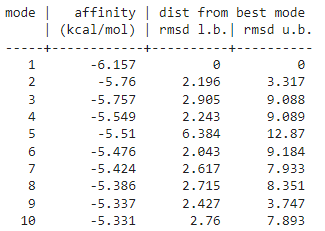

To view the docked complexes. Download the `receptor.pdbqt` file and the `ligand.pdbqt` file from the Google Drive folder. Then open both in the same Mol* or pyMol or other visualization program. It is possible to shuffle through the states and see all the poses.


---

The 10 poses can be viewed below in step 9 and saved in a folder in step 10. In your Google Drive, a new folder called sdf_poses will be created and populated with files. Each pose fill will be called `X_pose.sdf` where X corresponds to the mode_number. Then download the `receptor.pdb` file and the `X_pose.sdf` file and open them in the visualization software of your choosing.


In [ ]:
#@title **9: Best pose selection:**

mode_number = "4" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

view.addModel(open(receptor,'r').read(),'pdb')
Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'},'stick':{'radius':.1}})
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.2,'color':'white'})


view.addModel(open(res_box,'r').read(),'pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'grayCarbon','radius':0.2}})


#results=Chem.SDMolSupplier(ligand_out_sdf,False)
#p=Chem.MolToMolBlock(results[(int(mode_number)-1)],False)
#p2=Chem.MolToMolFile(results[(int(mode_number)-1)],(os.path.join(workDir, str(int(mode_number)) + "_pose.sdf")))

print('Reference residues: Gray | Uni-Dock Pose: Green')
view.addModel(ref_m,'mol')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

In [ ]:
#@title **10: Save the top 10 poses:**
# save all the .sdf pose files into a single folder
# Define the directory name
output_dir = os.path.join(workDir, "sdf_poses")

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for mode_number in range(1, 11):  # This creates a sequence from 1 to 10
       results = Chem.SDMolSupplier(ligand_out_sdf, False)
       p = Chem.MolToMolBlock(results[(mode_number - 1)], False)
       # Construct the output filename with the directory
       output_filename = os.path.join(output_dir, str(mode_number) + "_pose.sdf")
       p2 = Chem.MolToMolFile(results[(mode_number - 1)], output_filename)


# Next steps
Once you finish the Colab with a single ligand, you can pursue several other directions. **Before pursuing those directions, record all the binding values and download the pose files that you need from the Google Drive folder as they will be overwritten!**

###  Compare the same ligand binding to other pockets:

1.   Go back to step 4 and change the pocket number and run the code
2.   In step 5, change the values as needed for the docking box and run the code.
3.   Then run steps 8 and 9

###  Compare a different ligand binding to the same pocket:

1.   In step 6, input a new SMILES string and run the code
2.   Run all of steps 7, 8, and 9

Remember to save all files and values!



---



**For those who will perform MD on resulting complexes**
Follow the instructions above to download the protein and ligand. Then combine the two files together into a single PDB file.


**To visualize your results in 2-D, use this [colab](https://colab.research.google.com/drive/1vn9mT3b4kS-eWQFAesizt9pevyiq9S1X?usp=sharing)**